# Motivation
The goal of this code is to use neural network as a feature extractor. Instead of coming up with phase space variables for the Q-Factor analysis maybe we can use a neural network to determine this for us. 

We saw that Q-Factors performs well on a0+a2, purely combinatorial background. Performs poorly when combined with more background especially from b1 background. If we can include some phase space variables that helps separate out b1 signal from a0 or a2 signal MC then we might be able to perfrom better

In [1]:
from root_pandas import read_root
import ROOT
from array import array
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import random

import gc
import GPUtil
import torch # pytorch is a machine learning library 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 

Welcome to JupyROOT 6.22/05


In [2]:
gc.collect()
torch.cuda.memory_cached()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  3% |


/home/lawrence/anaconda3/lib/python3.8/site-packages/torch/cuda/memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [3]:
print ('Available devices ', torch.cuda.device_count()) 
print ('Current cuda device ', torch.cuda.current_device())
print ('GPU model ', torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Available devices  1
Current cuda device  0
GPU model  GeForce GTX 1050


In [4]:
# this is very weird. Even at the stage, if I push a very small tensor to GPU it takes up a lot of memory.
# we can see this by using nividia-smi before and after

#torch.tensor([1.8342169,1.]).to(device)

# Data exploration

In [5]:
# columns=[
#         "mcprocess",
#         "cosTheta_eta_gj",
#         "Mpi0g1",
#         "Mpi0g2",
#         "cosTheta_X_cm",   
#         "phi_eta_gj"
#         ]

photons=["g1","g2","g3","g4"]
moms=["px","py","pz","e"]
columns=["mcprocess"]
phaseSpace=["vanHove_omega",
        "pi0_energy",
        "mandelstam_teta",
        "cosThetaHighestEphotonIneta_gj"]
p4vars=[]
for photon in photons:
    for mom in moms:
        p4vars.append(photon+"_p4_kin_"+mom)
columns += phaseSpace
columns += p4vars

In [6]:
discrimVars=["Mpi0","Meta"]


dataFileLoc="./allMC_trees_lorentz.root"
treeName="degALL_acc_mEllipse_tree_flat"
df=read_root(dataFileLoc,treeName,
             columns=columns+discrimVars)

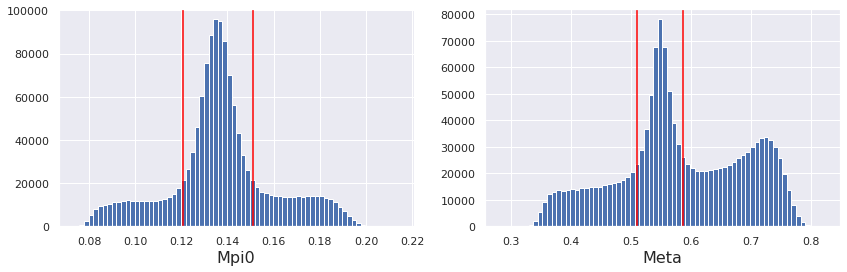

In [7]:
xmean=0.135881
ymean=0.548625
xstd=0.0076*2
ystd=0.0191*2

fig,axes=plt.subplots(1,2,figsize=(14,4))
df.Mpi0.hist(bins=70,ax=axes[0])
axes[0].set_xlabel("Mpi0",size=16)
axes[0].axvline((xmean-xstd),c='red')
axes[0].axvline((xmean+xstd),c='red')
df.Meta.hist(bins=70,ax=axes[1])
axes[1].set_xlabel("Meta",size=16)
axes[1].axvline((ymean-ystd),c='red')
axes[1].axvline((ymean+ystd),c='red')

In [8]:
region=""
if region=="sigRegion":
    df = df[
        (df.Meta>(ymean-ystd)) &
        (df.Meta<(ymean+ystd)) &
        (df.Mpi0>(xmean-xstd)) &
        (df.Mpi0<(xmean+xstd))
      ]

In [9]:
def drawAxes(nVars,nColsPlot=2):
    nRows=int(nVars/nColsPlot)+int(nVars%nColsPlot>0)
    fig, axes = plt.subplots(nRows,nColsPlot,figsize=(16,nRows*6))
    axes=axes.flatten()
    return fig,axes

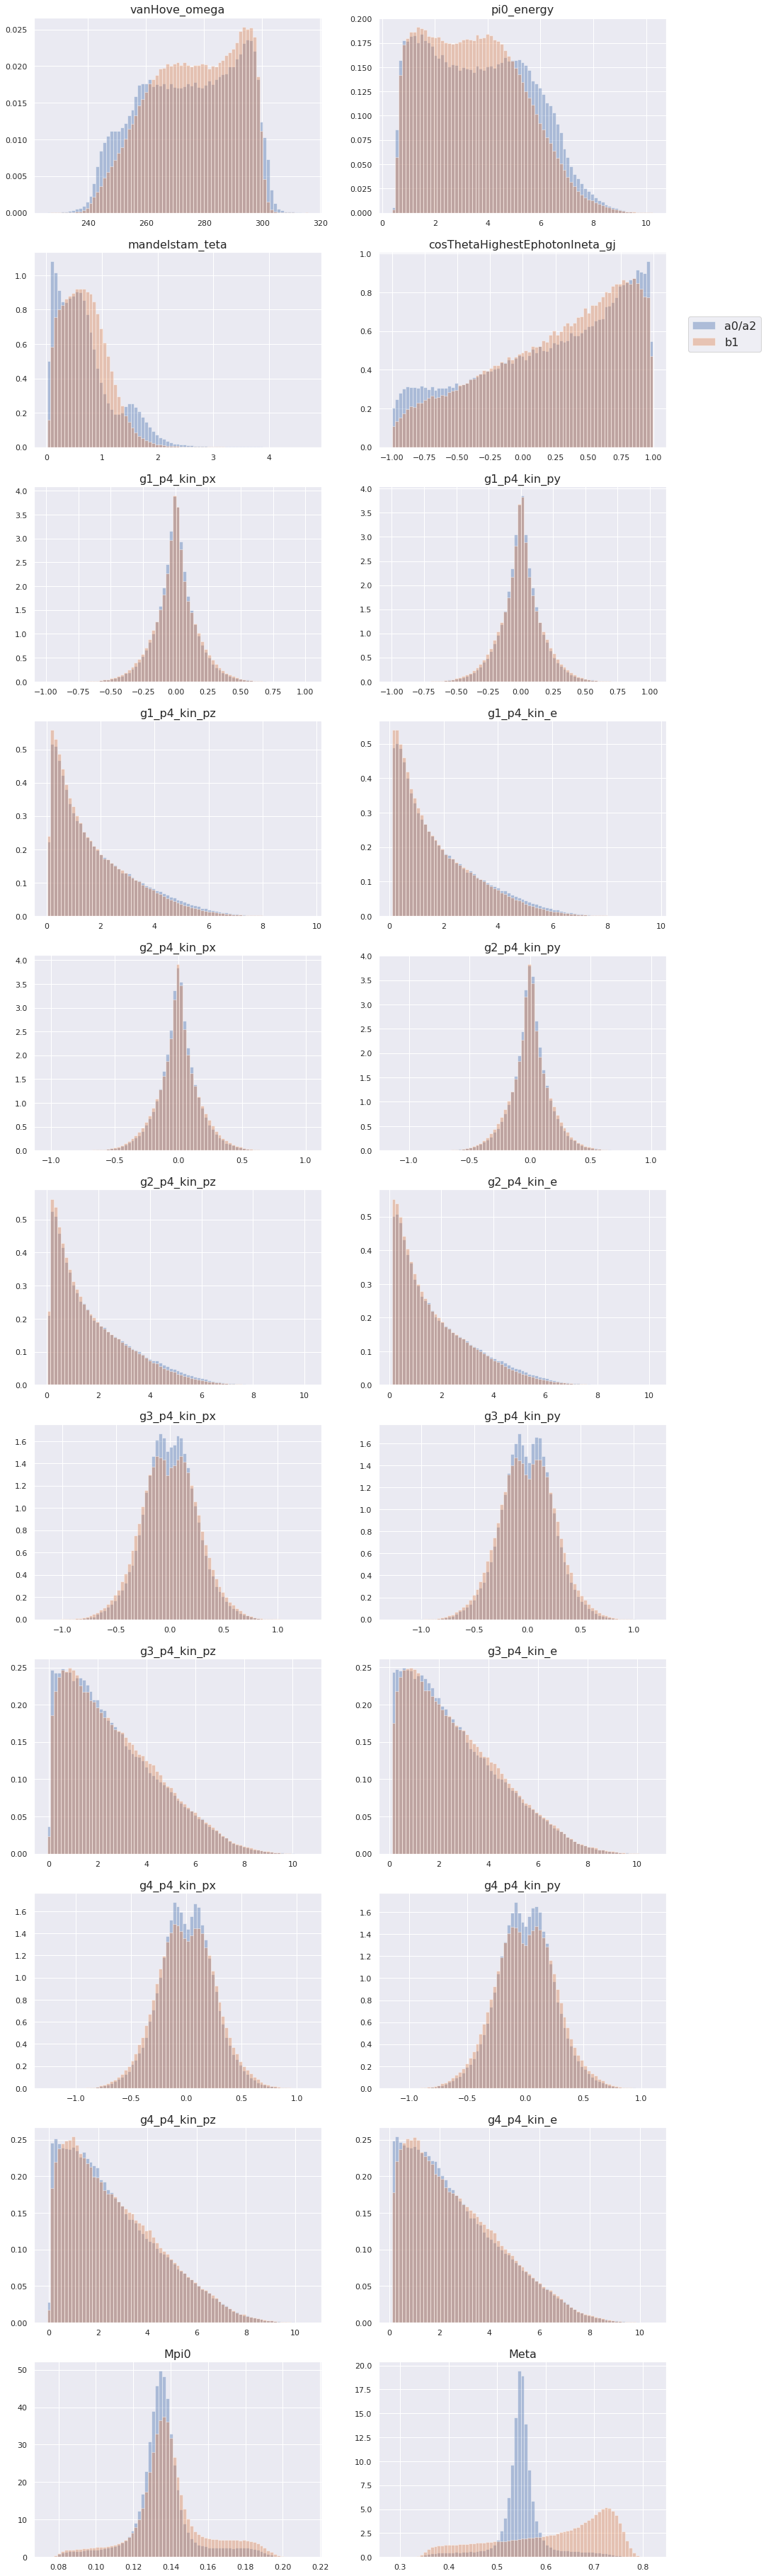

In [10]:
procs=[0,1,2]
colors=sns.color_palette()[:3]

fig,axes=drawAxes(len(columns+discrimVars)-1,2)
# sum a0/a2 datasets
for iax,col in enumerate(columns[1:]+discrimVars):
    binedges=np.histogram(df[col],bins=75)[1]
    df[(df.mcprocess==0) | (df.mcprocess==1)][col].hist(bins=binedges,density=True,alpha=0.4,
                                         label="a0/a2",ax=axes[iax],color=colors[0])
    axes[iax].set_title(col,size=16)
# draw b1 dataset
for iax,col in enumerate(columns[1:]+discrimVars):
    binedges=np.histogram(df[col],bins=75)[1]
    df[df.mcprocess==2][col].hist(bins=binedges,density=True,alpha=0.4,
                                         label="b1",ax=axes[iax],color=colors[1])
axes[1].legend(prop={"size":16},bbox_to_anchor=(1.35,-0.5))

In [11]:
def overlayHist(data1,selector,var,procs,ax,colors):
    '''
    Looks for "var" in data1 using selector as a selector
    '''
    binedges=np.histogram(data1[var],bins=75)[1]
    for proc in procs:
        data1[selector==proc][var].hist(bins=binedges,density=True,alpha=0.4,
                                             label=mapIDtoProc[proc],ax=ax,color=colors[proc])
        ax.set_title(var,size=16)

In [12]:
# mapIDtoProc={
#     0:"a0",
#     1:"a2",
#     2:"b1to5g",
#     3:"a2pi",
#     4:"etap",
#     5:"eta",
#     6:"f1_1285",
#     7:"omega",
#     8:"pi0pi0"
# }
# procs=[0,1,2]
# colors=sns.color_palette()[:3]
# fig,axes=drawAxes(len(discrimVars)-1,2)
# for iax,col in enumerate(discrimVars):
#     overlayHist(df,df.mcprocess,col,procs,axes[iax],colors=colors)
# axes[1].legend(prop={"size":16},bbox_to_anchor=(1.35,-0.5))

# Prepare data for pytorch

In [13]:
class modelDataset(Dataset):
    def __init__(self, dataX, dataY):
        self.dataX = dataX
        self.dataY = dataY
        
    def __len__(self):
        return len(self.dataX)
    
    def __getitem__(self, index):
        X = self.dataX[index]#.to(device)
        y = self.dataY[index]#.to(device)
        return X,y

In [14]:
#https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

In [15]:
def getClassDist(inputData, verbose=True):
    classCount=[]
    for someClass in np.arange(2):
        classCount.append((inputData==someClass).sum().item())
    classDist = np.array(classCount)
    classDist = classDist/classDist.sum()
    classWeights = classDist/classDist.max()
    classWeights[classWeights!=0] = 1/classWeights[classWeights!=0] 
    if verbose:
        print("counts in a given class:", end="")
        print(classCount)
        print("class distribution: ", end="")
        print(classDist)
        print("class weights: ", end="")
        print(classWeights)
    return classDist, classWeights

In [16]:
def train_model(model, loader, n_epochs, loss_fn, softmaxLayer, verbose=True):
    '''
    This will perform the training for n_epochs. Input data is passed forward in batches, gradients are 
    zeroed and updated on the backpropagation step. Losses are accumulated and the sum is saved in the
    lossArray that will be outputted
    '''
    # Sets model to TRAIN mode
    model.train()
    losses = []
    batchAccuracy = []
    for epoch in range(n_epochs):
        running_loss = 0.0
        nBatches=0
        accuracy=0
        for i,data in enumerate(loader):
            X_batch, y_batch = data
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # Have to zero the gradients first since in pytorch gradients are accumulated
            optimizer.zero_grad()
            # Makes predictions
            predMatrix = model(X_batch)
            preds = torch.argmax(softmaxLayer(predMatrix),dim=1)
            accuracy += (preds==y_batch).sum().item()/len(y_batch)
            nBatches=i
            # Computes loss
            loss = loss_fn(predMatrix, y_batch)
            # do backpropagation
            loss.backward()
            # Updates parameters
            optimizer.step()
            
            # accumulates loss
            running_loss += loss.item()
            
        # Returns the loss
        avgAccuracy=accuracy/nBatches
        avgLoss=running_loss/nBatches
        losses.append(avgLoss)
        batchAccuracy.append(avgAccuracy)
        print('epoch %d - avg epoch loss %f - avg batch accuracy %f' % (epoch+1, avgLoss, avgAccuracy))
    return losses, batchAccuracy

In [17]:
def plotLoss(lossArray,n_epochs):
    '''
    Very simple plotter for loss vs epoch
    '''
    fig,ax=plt.subplots(1,1,figsize=(8,4))
    ax.set_xlabel("epoch",size=16)
    ax.set_ylabel("loss (avg mse)", size=16)
    ax.plot(range(1,n_epochs+1),lossArray)

In [18]:
data = df[df.mcprocess<3]
dataX = data.drop(["mcprocess"],axis=1)
dataY = data.mcprocess
# grouping a0 and a2 into one class and b1 as the other
binaryClassMap = {
    0:0,
    1:0,
    2:1
}
dataY = dataY.map(binaryClassMap)

In [19]:
# Train test split + Standard scale
dataX_train_full, dataX_test_full, dataY_train, dataY_test = train_test_split(dataX,dataY,test_size=.15,random_state=14)
dataX_train_unscaled = dataX_train_full.drop(discrimVars,axis=1)
dataX_test_unscaled = dataX_test_full.drop(discrimVars,axis=1)

scaler = StandardScaler()
dataX_train = scaler.fit_transform(dataX_train_unscaled.values).astype(np.float32)
dataX_test = scaler.transform(dataX_test_unscaled.values).astype(np.float32)
dataY_train = dataY_train.values.astype(np.long)
dataY_test = dataY_test.values.astype(np.long)
print("shape of x train: ",end="")
print(*dataX_train.shape,sep=",")
print("shape of x test: ",end="")
print(*dataX_test.shape,sep=",")


# Import into torch
dataX_train = torch.tensor(dataX_train).to(device)
dataX_test = torch.tensor(dataX_test).to(device)
dataY_train = torch.tensor(dataY_train).to(device)
dataY_test = torch.tensor(dataY_test).to(device)

shape of x train: 937182,20
shape of x test: 165386,20


In [20]:
# make the dataset and the loader
batchSize=1024
dataset=modelDataset(dataX_train, dataY_train)
# loader=DataLoader(dataset,batch_size=batchSize,shuffle=True,num_workers=0)
classDist, classWeights = getClassDist(dataY_train)

counts in a given class:[330667, 606515]
class distribution: [0.35283115 0.64716885]
class weights: [1.8342169 1.       ]


In [21]:
%%prun -s cumulative -q -l 20 -T prun_forLoop
# Speed of the first two is about the same whereas the last is almost 100x slower. There is a big
# difference between dataloader getting the indicies+stacking them vs loading them through slicing

# num_batches=int(np.ceil(len(dataset)/64))
# batch_size=batchSize
# for batch_idx in range(num_batches):
#     dataset.dataX[batch_idx*batch_size:(batch_idx+1)*batch_size]
#     dataset.dataY[batch_idx*batch_size:(batch_idx+1)*batch_size]

loader=FastTensorDataLoader(dataset.dataX, dataset.dataY, batch_size=1024, shuffle=False)
# for i,data in enumerate(loader):
#     continue

# loader=DataLoader(dataset,batch_size=64,shuffle=False,num_workers=0)
# for i,data in enumerate(loader):
#     continue

 
*** Profile printout saved to text file 'prun_forLoop'. 


# Build + Train model

In [22]:
# CrossEntropyLoss is the loss function we want to use. It combines both LogSoftmax and NLLLoss 
# into a single class. It is not recommended to use Softmax due to a well known overflow problem. 
# We will use the individual components since in the end we want  to get the probablities
# https://discuss.pytorch.org/t/multi-class-cross-entropy-loss-and-softmax-in-pytorch/24920/2
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

n_epochs = 50
lr=1e-2
weights=torch.tensor(classWeights,dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights)
softmaxLayer = nn.Softmax(dim=1) # dim=1 would make the probabilites sum to 1 for each batch. Used to get probabilities for classes
inputSize=dataX_train[0].shape[0]

model = nn.Sequential(
    nn.Linear(inputSize,200),
    nn.ReLU(),
    nn.Linear(200,100),
    nn.ReLU(),
    nn.Linear(100,2)
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)

Sequential(
  (0): Linear(in_features=20, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)


In [23]:
%%prun -s cumulative -q -l 20 -T prun_training
lossArray, accuracyArray = train_model(model, loader, n_epochs, loss_fn, softmaxLayer, verbose=False)

epoch 1 - avg epoch loss 0.468592 - avg batch accuracy 0.778343
epoch 2 - avg epoch loss 0.393449 - avg batch accuracy 0.826692
epoch 3 - avg epoch loss 0.378800 - avg batch accuracy 0.833789
epoch 4 - avg epoch loss 0.369472 - avg batch accuracy 0.837507
epoch 5 - avg epoch loss 0.363207 - avg batch accuracy 0.840510
epoch 6 - avg epoch loss 0.358776 - avg batch accuracy 0.842756
epoch 7 - avg epoch loss 0.355756 - avg batch accuracy 0.844390
epoch 8 - avg epoch loss 0.352824 - avg batch accuracy 0.845959
epoch 9 - avg epoch loss 0.350510 - avg batch accuracy 0.847095
epoch 10 - avg epoch loss 0.348138 - avg batch accuracy 0.848273
epoch 11 - avg epoch loss 0.346095 - avg batch accuracy 0.849257
epoch 12 - avg epoch loss 0.344566 - avg batch accuracy 0.850080
epoch 13 - avg epoch loss 0.342838 - avg batch accuracy 0.851003
epoch 14 - avg epoch loss 0.341695 - avg batch accuracy 0.851803
epoch 15 - avg epoch loss 0.340371 - avg batch accuracy 0.852317
epoch 16 - avg epoch loss 0.339250

# Draw loss and accuracy curves

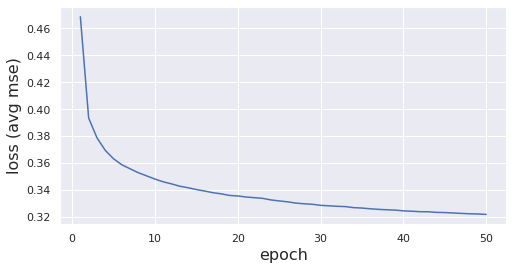

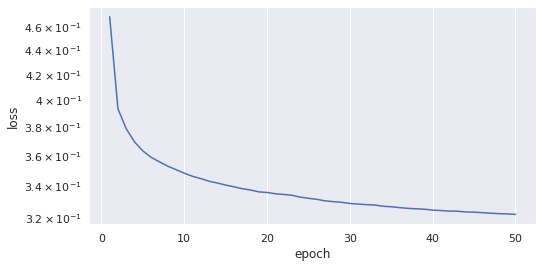

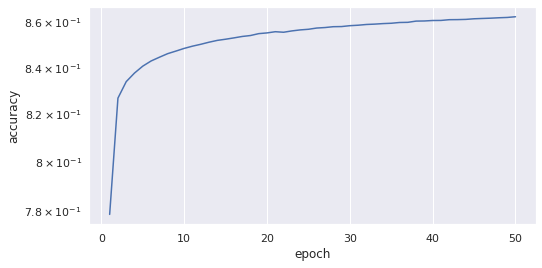

In [24]:
plotLoss(lossArray,n_epochs)

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, n_epochs+1), lossArray)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, n_epochs+1), accuracyArray)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.yscale('log')
plt.show()

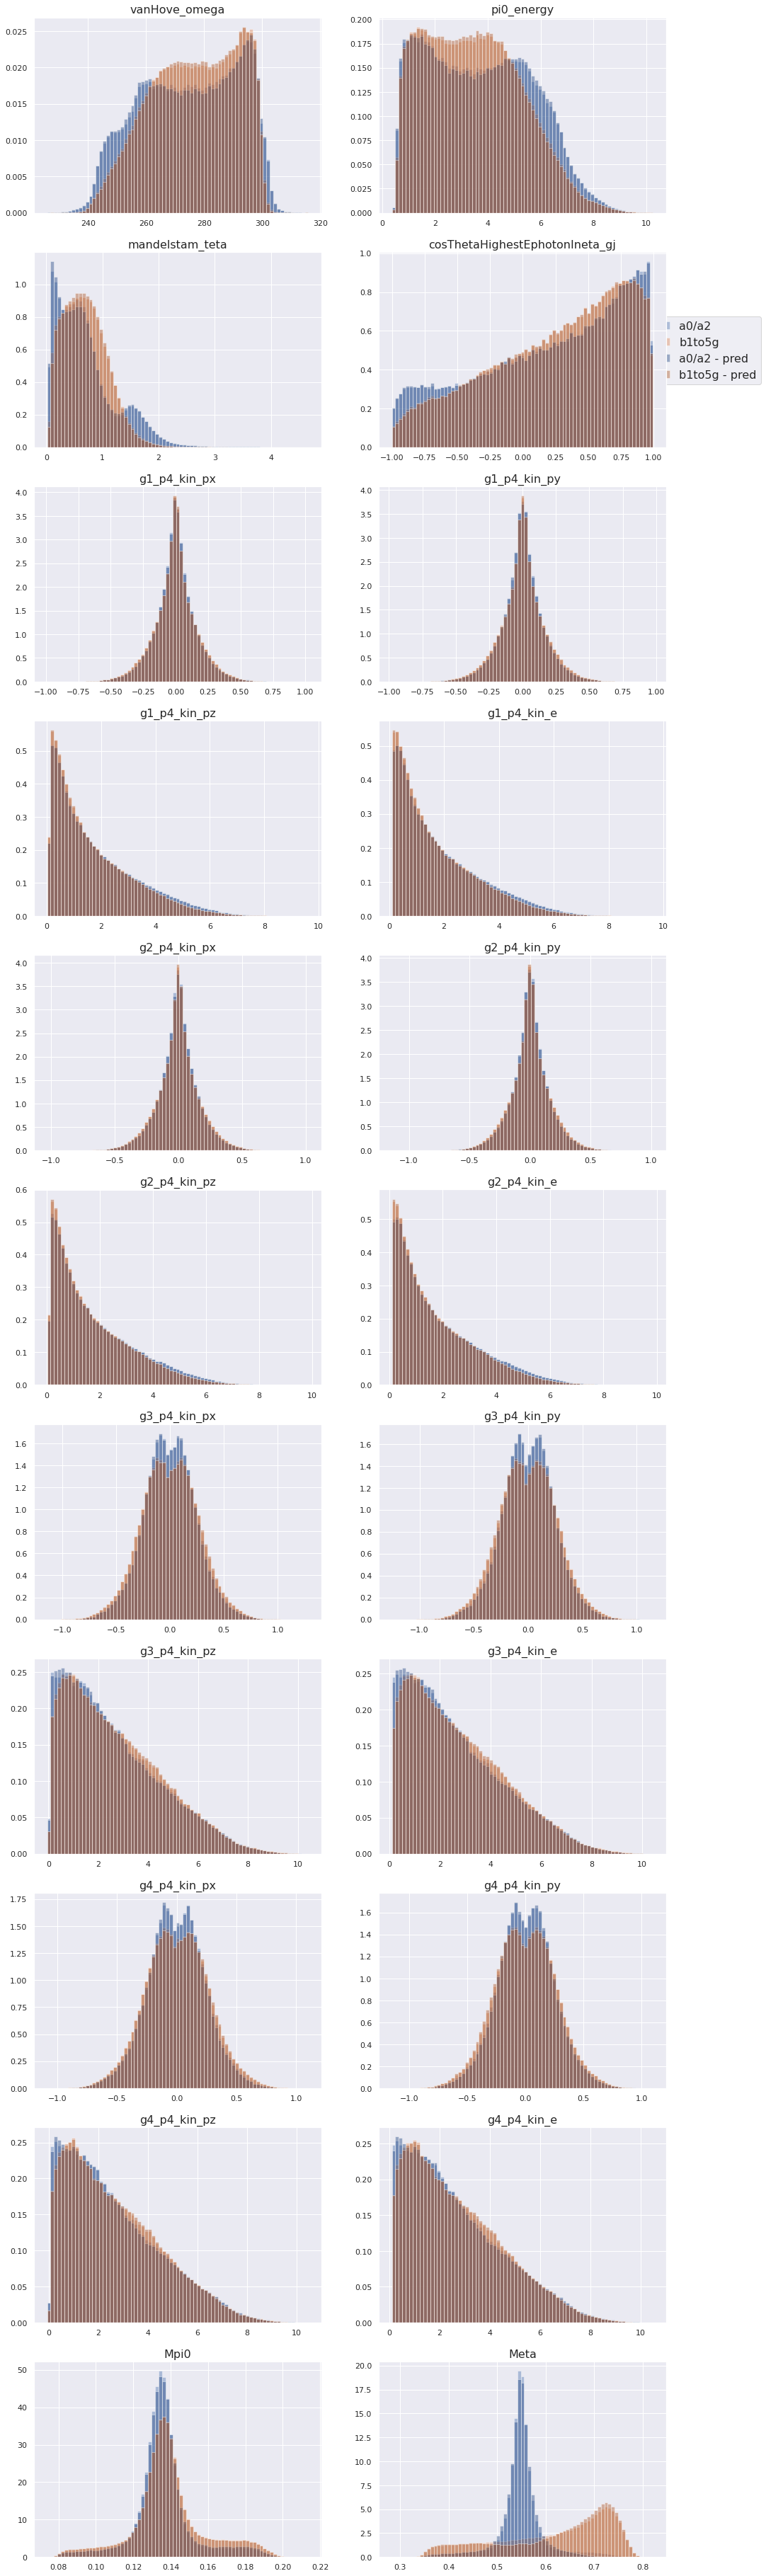

In [25]:
model.cpu()
dataX_train=dataX_train.cpu()
dataY_train=dataY_train.cpu()
dataX_test=dataX_test.cpu()
dataY_test=dataY_test.cpu()

preSoftMax = model(dataX_train)
prob, preds = torch.topk(softmaxLayer(preSoftMax),1,1)

allVars=columns+discrimVars
allVars=allVars[1:]

fig, axes = drawAxes(len(allVars),2)

mapIDtoProc={
    0:"a0/a2",
    1:"b1to5g",
}
procs=[0,1]
colors=sns.color_palette()[:2]
for iax,col in enumerate(allVars):
    overlayHist(dataX_train_full,pd.Series(dataY_train.cpu(),index=dataX_train_full.index),
                col,procs,axes[iax],colors=colors)


mapIDtoProc={
    0:"a0/a2 - pred",
    1:"b1to5g - pred",
}
colors=np.array(colors)-0.2
for iax,col in enumerate(allVars):
    overlayHist(dataX_train_full,pd.Series(preds.flatten().cpu(),index=dataX_train_full.index),
                col,procs,axes[iax],colors=colors)
axes[1].legend(prop={"size":16},bbox_to_anchor=(1.35,-0.5))


# Plot softmax output to see separability

In [26]:
def constructLayerDF(layer):
    subModel = model[:layer+1]
    print(subModel)
    out = subModel(dataX_train).cpu().detach().numpy()
    nNodes = out.shape[1]
    colNames=[]
    for i in range(nNodes):
        colNames.append("node"+str(i))
    colNames.append("mcprocess")
    temp_df = pd.DataFrame(np.append(out,dataY_train.cpu().numpy()[:,None],1),columns=colNames)
    return temp_df, nNodes

In [27]:
def drawLayer(layer):
    temp_df,nNodes=constructLayerDF(layer)
    fig,axes=drawAxes(nNodes,2)
    for i in range(nNodes):
        binedges=np.histogram(temp_df["node"+str(i)],bins=75)[1]
        temp_df.loc[temp_df.mcprocess==0,"node"+str(i)].plot(kind="hist", bins=binedges,ax=axes[i],
                                                             density=True,alpha=0.4)
        temp_df.loc[temp_df.mcprocess==1,"node"+str(i)].plot(kind="hist", bins=binedges,ax=axes[i],
                                                             density=True,alpha=0.4)

Sequential(
  (0): Linear(in_features=20, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)


Text(0.5, 1.0, 'node0 post softmax')

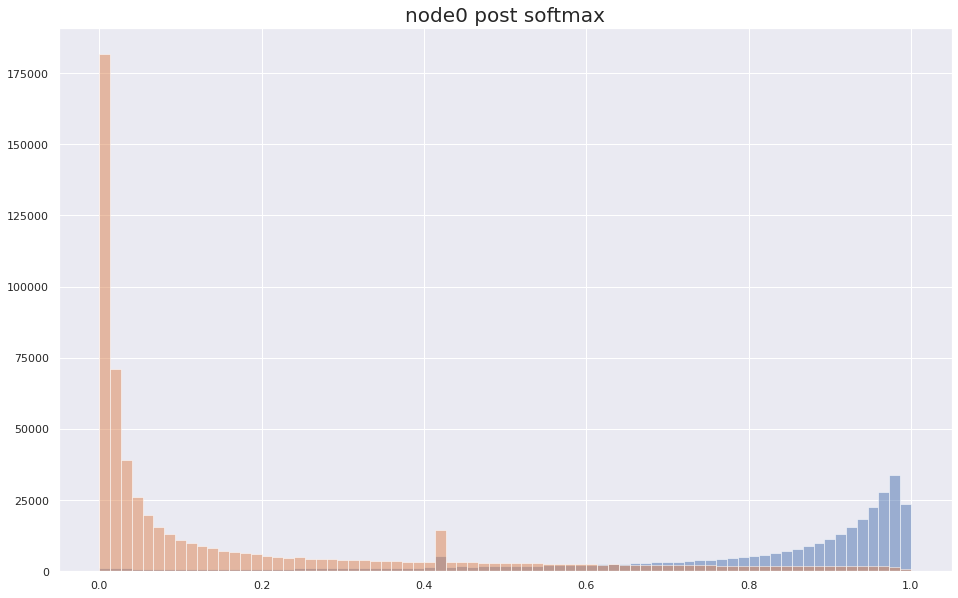

In [28]:
temp_df,nNodes=constructLayerDF(4)
mc_process = temp_df.mcprocess.values
temp_df = softmaxLayer(torch.tensor(temp_df.drop("mcprocess",axis=1).values).to(device))
temp_df = temp_df.cpu().numpy()
temp_df = pd.DataFrame(np.append(temp_df,mc_process[:,None],1),columns=["node0","node1","mcprocess"])

binedges=np.histogram(temp_df["node0"],bins=75)[1]
count1, edges1 = np.histogram(temp_df.loc[temp_df.mcprocess==0,"node0"],bins=binedges)
count2, edges2 = np.histogram(temp_df.loc[temp_df.mcprocess==1,"node0"],bins=binedges)
fig,ax=plt.subplots(figsize=(16,10))
plt.hist(temp_df.loc[temp_df.mcprocess==0,"node0"], bins=binedges,alpha=0.5)
plt.hist(temp_df.loc[temp_df.mcprocess==1,"node0"], bins=binedges,alpha=0.5)
plt.title("node0 post softmax",size=20)

Sequential(
  (0): Linear(in_features=20, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)


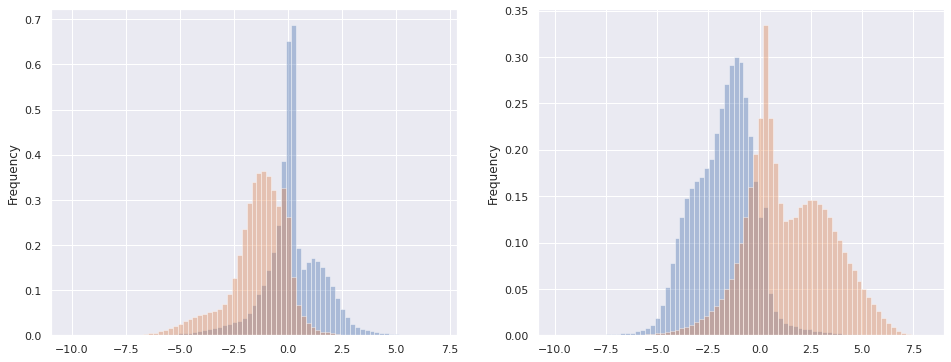

In [29]:
drawLayer(4)

In [30]:
#drawLayer(2)

# How to quantify results?

In [31]:
def getNN(df_distances, rndIdx):
    df_distances=(df_distances.drop(rndIdx)-df_distances.iloc[rndIdx])
    df_distances=df_distances**2
    df_distances=df_distances.sum(axis=1)
    df_kNN=df_distances.sort_values()[:kNN]
    return df_kNN.index, df_kNN.values

In [32]:
layer_df,nNodes=constructLayerDF(4)
mc_process = layer_df.mcprocess.values
layer_df=layer_df.drop("mcprocess",axis=1)

softmaxed_df = softmaxLayer(torch.tensor(layer_df.values).to(device))
softmaxed_df = softmaxed_df.cpu().numpy()
softmaxed_df = pd.DataFrame(softmaxed_df,columns=layer_df.columns)

scalerLayer=StandardScaler()
layer_df_scaled=pd.DataFrame(scalerLayer.fit_transform(layer_df),columns=layer_df.columns)

Sequential(
  (0): Linear(in_features=20, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)


In [33]:
def fillNa(df):
    if 0 not in df.index:
        df[0]=0
    if 1 not in df.index:
        df[1]=0

In [34]:
if not isinstance(dataY_train,pd.core.series.Series):
    dataY_train_df=pd.Series(dataY_train.cpu().numpy(),dtype=int)
if not isinstance(dataX_train,pd.core.frame.DataFrame):
    dataX_train_df=pd.DataFrame(dataX_train.cpu().numpy(),columns=dataX_train_unscaled.columns)

In [43]:
if not isinstance(dataY_train,pd.core.series.Series):
    dataY_train_df=pd.Series(dataY_train.cpu().numpy(),dtype=int)
if not isinstance(dataX_train,pd.core.frame.DataFrame):
    dataX_train_df=pd.DataFrame(dataX_train.cpu().numpy(),columns=dataX_train_unscaled.columns)
    dataX_train_df=dataX_train_df.drop(p4vars,axis=1)
    

nRndSamp=100
extraCondition=(dataX_train_full.Meta>(ymean-ystd)) & (dataX_train_full.Meta<(ymean+ystd)) & (dataX_train_full.Mpi0>(xmean-xstd)) &(dataX_train_full.Mpi0<(xmean+xstd))
extraCondition=extraCondition.reset_index(drop=True)
extraCondition=True
rndSubset_b1=random.sample(list(dataY_train_df[(dataY_train_df==1) & extraCondition].index),nRndSamp)
kNN=300
classBalance={"sig":[], "b1":[], "indx":[]}
classBalanceMerged={"sig":[], "b1":[], "indx":[]}
classBalance_layer={"sig":[], "b1":[], "indx":[]}
classBalance_softmaxed={"sig":[], "b1":[], "indx":[]}
classBalanceMerged_softmaxed={"sig":[], "b1":[], "indx":[]}
classBalance_layer_scaled={"sig":[], "b1":[], "indx":[]}
for rndIdx in rndSubset_b1:
    indicies, distances = getNN(dataX_train_df, rndIdx)
    counts=dataY_train_df[indicies].value_counts()
    fillNa(counts)
    classBalance["sig"].append(counts[0])
    classBalance["b1"].append(counts[1])
    classBalance["indx"].append(indicies)
    
    indicies, distances = getNN(dataX_train_df.join(layer_df_scaled), rndIdx)
    counts=dataY_train_df[indicies].value_counts()
    fillNa(counts)
    classBalanceMerged["sig"].append(counts[0])
    classBalanceMerged["b1"].append(counts[1])
    classBalanceMerged["indx"].append(indicies)
    
    indicies, distances = getNN(softmaxed_df, rndIdx)
    counts=dataY_train_df[indicies].value_counts()
    fillNa(counts)
    classBalance_softmaxed["sig"].append(counts[0])
    classBalance_softmaxed["b1"].append(counts[1])
    classBalance_softmaxed["indx"].append(indicies)
    
    indicies, distances = getNN(dataX_train_df.join(softmaxed_df), rndIdx)
    counts=dataY_train_df[indicies].value_counts()
    fillNa(counts)
    classBalanceMerged_softmaxed["sig"].append(counts[0])
    classBalanceMerged_softmaxed["b1"].append(counts[1])
    classBalanceMerged_softmaxed["indx"].append(indicies)
    
    indicies, distances = getNN(layer_df, rndIdx)
    counts=dataY_train_df[indicies].value_counts()
    fillNa(counts)
    classBalance_layer["sig"].append(counts[0])
    classBalance_layer["b1"].append(counts[1])
    classBalance_layer["indx"].append(indicies)
    
    indicies, distances = getNN(layer_df_scaled, rndIdx)
    counts=dataY_train_df[indicies].value_counts()
    fillNa(counts)
    classBalance_layer_scaled["sig"].append(counts[0])
    classBalance_layer_scaled["b1"].append(counts[1])
    classBalance_layer_scaled["indx"].append(indicies)

data: 215.37
merged: 264.28
softmaxed: 263.47
merged_softmaxed: 264.31
layer: 263.16
layerScaled: 263.36


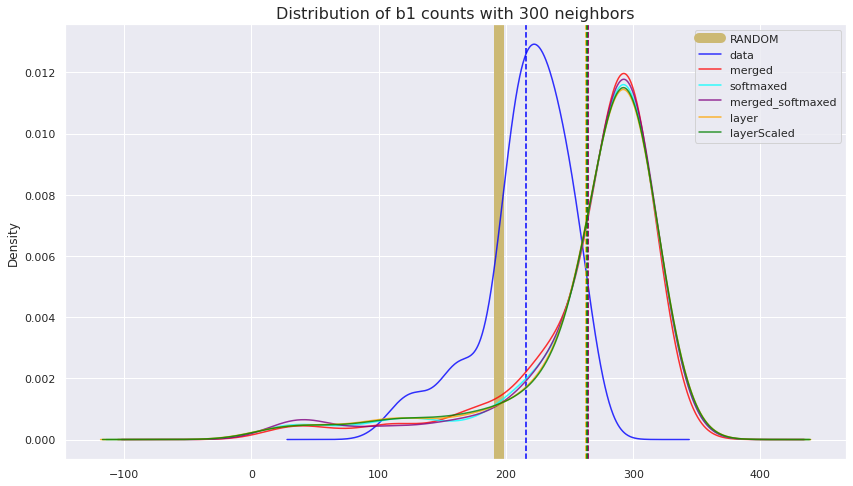

In [44]:
datasets=[classBalance,classBalanceMerged,classBalance_softmaxed,classBalanceMerged_softmaxed,
          classBalance_layer,classBalance_layer_scaled]
labels=["data","merged","softmaxed","merged_softmaxed","layer","layerScaled"]
colors=['blue','red','cyan','purple','orange','green']
plt.figure(figsize=(14,8))
avgRnd=dataY_train_df.value_counts()[1]/len(dataY_train_df)*kNN
plt.axvline(avgRnd,c="y",linewidth=10,label="RANDOM")
for i,dataset in enumerate(datasets):
    dataset["b1"]=pd.Series(dataset["b1"])
    dataset["b1"].plot.kde(c=colors[i],alpha=0.8,label=labels[i])
    plt.axvline(dataset["b1"].mean(),c=colors[i],linestyle='--')
    print(labels[i]+": "+str(dataset["b1"].mean()))
plt.title("Distribution of b1 counts with "+str(kNN)+" neighbors",size=16)
plt.legend()
plt.savefig("fullData_sigRegion.png")

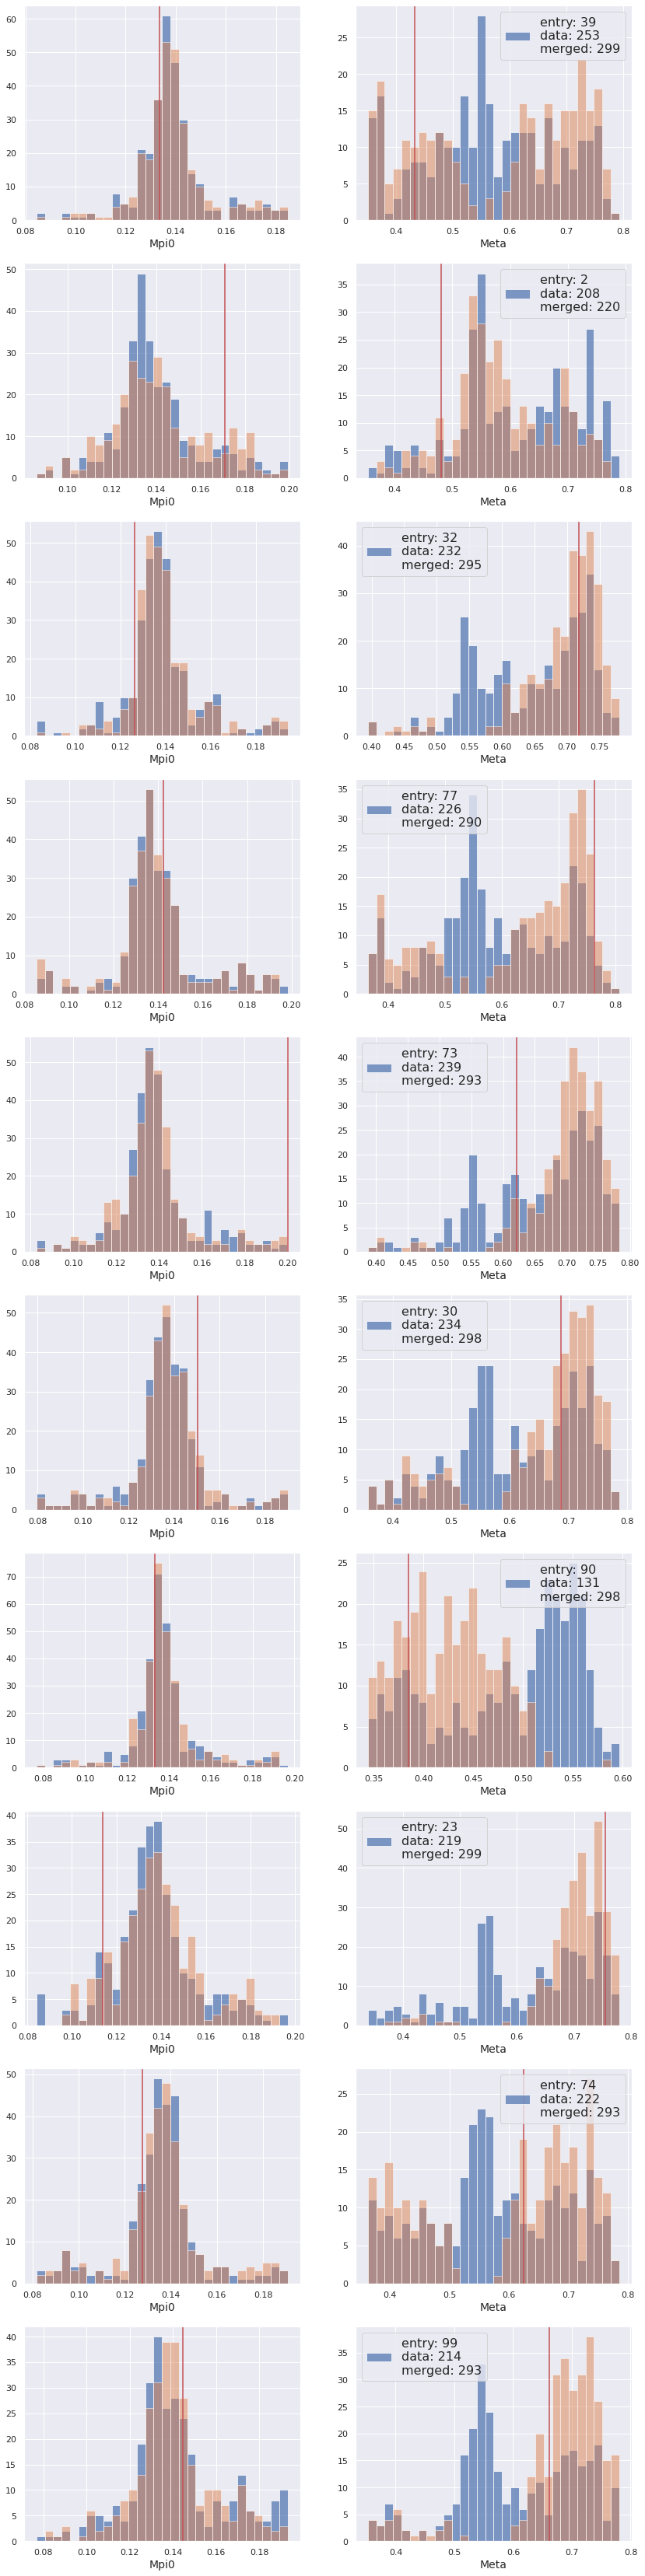

In [37]:
nExamples = 10

fig, ax = plt.subplots(nExamples,2,figsize=(14,6*nExamples))
for irow, i in enumerate(random.sample(range(nRndSamp),nExamples)):
    ax[irow,0].axvline(dataX_train_full.iloc[rndSubset_b1[i]].Mpi0,c='r')
    binedges=np.histogram(dataX_train_full.iloc[classBalance["indx"][i]].Mpi0,bins=30)[1]
    dataX_train_full.iloc[classBalance["indx"][i]].Mpi0.hist(bins=binedges,ax=ax[irow,0],alpha=0.7)
    dataX_train_full.iloc[classBalanceMerged_softmaxed["indx"][i]].Mpi0.hist(bins=binedges,ax=ax[irow,0],alpha=0.5)
    ax[irow,0].set_xlabel("Mpi0",size=14)

    ax[irow,1].axvline(dataX_train_full.iloc[rndSubset_b1[i]].Meta,c='r')
    num_b1=sum(dataY_train[classBalance["indx"][i]]==1).item()
    num_b1_merged=sum(dataY_train[classBalanceMerged_softmaxed["indx"][i]]==1).item()
    label="entry: "+str(i)+"\ndata: "+str(num_b1)+"\nmerged: "+str(num_b1_merged)
    binedges=np.histogram(dataX_train_full.iloc[classBalance["indx"][i]].Meta,bins=30)[1]
    dataX_train_full.iloc[classBalance["indx"][i]].Meta.hist(bins=binedges,ax=ax[irow,1],alpha=0.7,label=label)
    dataX_train_full.iloc[classBalanceMerged_softmaxed["indx"][i]].Meta.hist(bins=binedges,ax=ax[irow,1],alpha=0.5)
    ax[irow,1].set_xlabel("Meta",size=14)
    ax[irow,1].legend(prop={"size":16})

# Add new branches for the new discriminating variables

In [38]:
# del dataX_train
# torch.cuda.empty_cache()

In [39]:
# scaler.transform(df.drop(["mcprocess"]+discrimVars,axis=1))

In [40]:
# # trees are not meant to change. Clone the tree and write a new branch to it
# rt_file=ROOT.TFile.Open(dataFileLoc)
# rt_file_ext=ROOT.TFile.Open("allMC_tree_ext.root","RECREATE")

# tree_ext=rt_file.degALL_acc_mEllipse_tree_flat.CloneTree(-1,"fast")
# nn1 = array( 'd', [ 0 ] )
# newBranch=tree_ext.Branch("nn1",nn1,"nn1/D")
# nentries=rt_file.degALL_acc_mEllipse_tree_flat.GetEntries()

In [41]:
# for ientry in range(nentries):
#     nn1[0] = i
#     newBranch.Fill()
# tree_ext.Write()
# rt_file_ext.Close()